**Genetic Algorithm for Feature Selection**

Genetic Algorithms aim to replicate the behavior of genetic evolution, whereby the genetics of the individuals best suited to the environment persist over time.
The individuals in the population are evaluated according to an objective function or heuristic, which is used to choose the individuals to reproduce in each iteration. Those individuals that obtain a better result from the objective function will be chosen with a higher probability for reproduction (in nature, individuals with better genetics live longer and better, which allows them to reproduce more their genes). It is worth mentioning that the selection of individuals for reproduction is stochastic, so the best individuals will not always be selected, helping the algorithm not to fall into local minimums. After several generations, the best individual is selected as the final result. Now that the algorithm has been explained at a high level, more focus will be put on each step of the evolutionary process.

Found 2100 files belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 2000x1000 with 0 Axes>

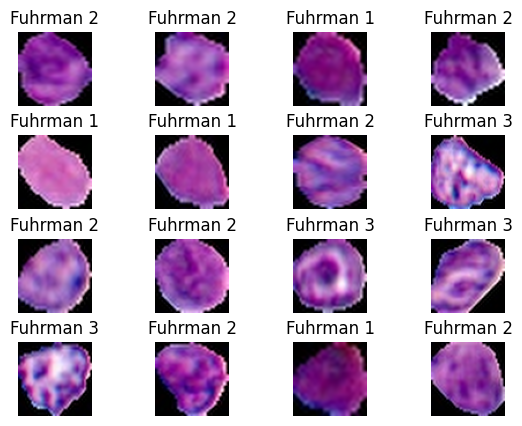

In [2]:
import os,math,random
import tensorflow as tf
import matplotlib.pyplot as plt
import time


path_to_images=os.path.join('..','dataset','Extracted Annotation Data','Cleared Image Patches')
batch_size=32
image_size=(64,64,3)


images = tf.keras.utils.image_dataset_from_directory(            
    directory=path_to_images,
    validation_split=None,
    subset=None,
    seed=1234,
    batch_size=batch_size,
    color_mode='rgb',
    image_size=image_size[:2],
    interpolation='lanczos5',
    crop_to_aspect_ratio=False
)

class_names=os.listdir(path_to_images)
num_classes=len(class_names)
raw_images,labels=tuple(zip(*images))
bioimage_data,bioimage_labels=tf.concat([image for image in raw_images],0),tf.concat([label for label in labels],0)


plt.figure(figsize=(20,10))
fig,axs=plt.subplots(4,4)
random.seed(time.time())
images=[random.randint(0,bioimage_data.shape[0]-1) for _ in range(16)]
cnt=0
for j in range(len(images)):
    if j!=0 and j%int(math.sqrt(len(images)))==0:
        cnt+=1
    axs[cnt,j%int(math.sqrt(len(images)))].imshow(tf.cast(bioimage_data[images[j]]/255, tf.float32))
    axs[cnt,j%int(math.sqrt(len(images)))].set_title(class_names[bioimage_labels[images[j]]])
    axs[cnt,j%int(math.sqrt(len(images)))].set_axis_off()

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

In [4]:
import numpy as np
from functools import reduce
import pandas as pd

base_model_name='resnet50'
lb,ub=0,16

base_model,pretrained_model_name=(tf.keras.applications.VGG16(weights='imagenet', input_shape=image_size, include_top=False),'VGG16') if base_model_name=='vgg16' else (tf.keras.applications.VGG19(weights='imagenet', input_shape=image_size, include_top=False),'VGG19') if base_model_name=='vgg19' else (tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=image_size, include_top=False),'RESNET50') if base_model_name=='resnet50' else (tf.keras.applications.ResNet101V2(weights='imagenet', input_shape=image_size, include_top=False),'resnet101')
base_model.trainable = True
for layer in base_model.layers[lb:ub]:
    layer.trainable = False
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=image_size,name='feature_extractor_input_layer'))
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D(name='average_pooling_layer'))



pretrained_model_name = base_model_name
feature_set = list()
labels = list()
for i in range(0, bioimage_data.shape[0] // batch_size):
    batch_indeces = list(range(i, i + batch_size))
    batch_images = []

    for image_index in batch_indeces:
        image = np.array(bioimage_data[image_index])
        image = np.expand_dims(image, axis=0)
        image = tf.keras.applications.imagenet_utils.preprocess_input(image)
        batch_images.append(image)

    batch_images = np.vstack(batch_images)
    features = model.predict(batch_images, batch_size=batch_size)
    output_shape = model.layers[-1].output.shape
    flatten_shape = reduce(lambda a, b: a * b, [x for x in list(output_shape) if type(x) == int])
    features = np.reshape(features, (-1, flatten_shape))
    feature_set.append(features)
    labels.append(np.array(bioimage_labels[i:i + batch_size]))

# Convert features and labels to arrays
feature_set = np.vstack(feature_set)
labels = np.hstack(labels)

# Save extracted features and labels to CSV file
data=list()
for i in range(feature_set.shape[0]):
    row=list()
    for j in range(feature_set.shape[1]):
        row.append(feature_set[i][j])
    row.append(labels[i])
    data.append(row)
bioimage_dataframe=pd.DataFrame(data,columns=[f'F{i+1}' for i in range(len(feature_set[0]))]+['Fuhrman'])
print(bioimage_dataframe.describe())

1/1 [==============================] - 0s 110ms/step
                F1           F2           F3           F4           F5  \
count  2080.000000  2080.000000  2080.000000  2080.000000  2080.000000   
mean    537.792175    72.552895   188.485840   315.838928   121.140327   
std     144.933182    85.005791    98.276970   123.670135    99.665833   
min     220.559464     0.000000     0.000000     0.000000     0.000000   
25%     419.432220     0.000000   116.366028   248.271164    50.982559   
50%     542.062256    41.144524   196.731415   353.760803    96.865135   
75%     625.285400   133.707672   267.258759   392.450531   183.849243   
max    1082.899902   455.843201   358.859375   643.368774   431.546631   

           F6           F7           F8           F9          F10  ...  \
count  2080.0  2080.000000  2080.000000  2080.000000  2080.000000  ...   
mean      0.0   234.923080    39.057236   231.206894     0.420851  ...   
std       0.0   118.295830    38.324825    82.736977     3

### Genetic Algorithm 

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import copy,optuna
from rich.console import Console

class GeneticSelector:
    def __init__(self,x_train,x_test,y_train,y_test,normalize='MinMax'):
        self.xtrain=x_train
        self.xtest=x_test
        self.ytrain=y_train
        self.ytest=y_test
        self.scaler=MinMaxScaler() if normalize=='MinMax' else StandardScaler() if normalize=='Standardization' else KNNImputer(n_neighbors=10)
        self.model=None

    def get_n_individual(self,counter,population):
        index=counter+1
        propabilities=[ind[1] for ind in population]
        sorted_probs=sorted(propabilities,key=float)
        max_prob=sorted_probs[-index]
        return [ind[0] for ind in population if ind[1]==max_prob][0]

    # tune max features number
    def generate_random_individuals(self,num_individuals,num_features,max_features=None):
        individuals=list()
        for _ in range(num_individuals):
            individual=''
            for _ in range(num_features):
                if individual.count('1')==max_features:
                    individual+='0'
                    continue
                individual+=str(random.randint(0,1))
            individuals.append(individual)
        return individuals

    def create_model(self):
        if self.model:
            return
        self.model=tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(32,input_dim=self.xtrain.shape[1],activation='relu'))
        self.model.add(tf.keras.layers.Dense(64,activation='relu'))
        self.model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

        self.model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    def get_weights(self,population):
        total_accuracies=sum([individual[1] for individual in population])
        return [(individual[0],(individual[1]/total_accuracies)*100) for individual in population]

    def fitness_func(self,individual):
        self.create_model()  
        X_train=pd.DataFrame(data=self.scaler.fit_transform(self.xtrain),columns=self.xtrain.columns.to_list())
        X_test=pd.DataFrame(data=self.scaler.fit_transform(self.xtest),columns=self.xtest.columns.to_list())

        X_train=X_train.loc[:,[True if individual[i]=='1' else False for i in range(len(individual))]]
        X_test=X_test.loc[:,[True if individual[i]=='1' else False for i in range(len(individual))]]

        xtrain_np=np.asarray(X_train).astype(np.float64)
        xtest_np=np.asarray(X_test).astype(np.float64)
        ytrain_np=np.asarray(self.ytrain).astype(np.float64)
        ytest_np=np.asarray(self.ytest).astype(np.float64)

        self.model.fit(xtrain_np,ytrain_np,epochs=100,verbose=1)
        pred=self.model.predict(xtest_np)

        return accuracy_score(ytest_np,pred)

    def fill_population(self,individuals,goal_value=0.8):
        population=list()

        for individual in individuals:
            accuracy=self.fitness_func(individual)
            if float(accuracy)>goal_value:
                return individual
            population.append((individual,accuracy))
        return self.get_weights(population)

    def choose_parents(self,population,counter):
        if counter==0:
            parent_1=self.get_n_individual(0,population)
            parent_2=self.get_n_individual(1,population)
        elif counter==1:
            parent_1=self.get_n_individual(0,population)
            parent_2=self.get_n_individual(2,population)
        else:
            propabilities=(individual[1] for individual in population)
            individuals=[individual[0] for individual in population]
            parent_1,parent_2=random.choices(individuals,weights=propabilities,k=2)
        
        return parent_1,parent_2

    def mutate(self,child,prob=0.1):
        new_child=copy.deepcopy(child)
        for i,charv in enumerate(new_child):
            if random.random()<prob:
                new_value='1' if charv=='0' else '0'
                new_child=new_child[:i]+new_value+new_child[i+1:]
        return new_child
    
    def reproduce(self,individual_1,individual_2):
        crosspoint=random.randint(1,len(individual_1)-1)
        child_1=individual_1[:crosspoint]+individual_2[crosspoint:]
        child_2=individual_2[:crosspoint]+individual_1[crosspoint:]
        child_1,child_2=self.mutate(child_1),self.mutate(child_2)

        return [child_1,child_2]
    
    def genaration_ahead(self,population):
        new_population=list()
        for i in range(int(len(population))//2):
            parents=self.choose_parents(population,counter=i)
            childs=self.reproduce(parents[0],parents[1])
            new_population.append(childs)
        return new_population

    def solve(self,ind_num,max_features,max_iter=10):
        individuals=self.generate_random_individuals(ind_num,len(self.xtrain.columns.to_list()),max_features)
        population=self.fill_population(individuals)
        if isinstance(population,str):
            return population
        
        new_generation=self.generation_ahead(population)
        iter_id=0
        while iter_id<max_iter:
            print(f'Iteration Number:{iter_id}/Max iter:{max_iter}')
            population=self.fill_population(new_generation)
            if isinstance(population,str):
                break

            new_generation=self.generation_ahead(population)
            iter_id+=1
        return population


### Feature Selection

In [10]:
print(bioimage_dataframe)

train_set,test_set=train_test_split(bioimage_dataframe,test_size=0.14286)

print(f'{train_set.shape=}   {test_set.shape=}')
features=bioimage_dataframe.columns.to_list()
target=features[-1]
features.remove(target)


xtrain=train_set[features]
xtest=test_set[features]
ytrain=train_set[target]
ytest=test_set[target]


selector=GeneticSelector(xtrain,xtest,ytrain,ytest)
selector.solve(ind_num=len(xtrain.columns.to_list())*10,max_features=10,max_iters=100)


              F1          F2          F3          F4          F5   F6  \
0     357.101074    0.000000   50.708401  136.736176  109.830231  0.0   
1     480.356964  171.044128  213.581512  352.032898   66.102890  0.0   
2     589.036987    0.000000  220.330688  240.337280   78.373230  0.0   
3     776.415161    0.000000    0.000000  187.242340  363.293213  0.0   
4     623.677612  172.654419  137.267776  271.580292   91.730438  0.0   
...          ...         ...         ...         ...         ...  ...   
2075  365.389618    0.000000   95.521713  119.954521  109.970047  0.0   
2076  741.375549    0.000000  196.321594    0.000000  136.232697  0.0   
2077  669.030029   98.456894  106.283813  432.333588    0.000000  0.0   
2078  562.190308   26.690264  169.393005  414.595856  273.022461  0.0   
2079  377.400574  162.269760  290.677704  370.857178  117.882500  0.0   

              F7         F8          F9  F10  ...       F2040  F2041  \
0      60.834572   0.000000  206.543152  0.0  ...  